In [1]:
# Run but do not modify this code
import seaborn as sns
if ('0.11' in sns.__version__) or ('0.12' in sns.__version__):
    sns.set_theme()
else:
    sns.set()

In [2]:
import pandas as pd
sns.set_theme()
tumor_df = pd.read_csv("Data_Tanzanian-breast_cancer_TILS_Mremi_Hall (1).csv")
print(tumordata.shape)
tumor_df.head()

(323, 18)


,DeID,Ethnicity,Biomarker,TumorType,ER,Her2,Grade,GradeT,GradeN,GradeM,Tsizemm,Age,TILs,mits,Age50,grade1,TILs20,Tsize60
0,1,1,1,ductal,1,0,3,2,3,3,70.0,61,13,18,1,1,0,1
1,2,1,1,ductal,1,0,2,3,2,2,999.0,52,11,13,1,0,0,999
2,3,1,1,mucinous or mucinous fx\t,1,0,1,2,2,1,999.0,65,15,2,1,0,0,999
3,4,1,1,micropap or micropap fx\t,1,0,2,3,2,1,999.0,55,20,7,1,0,0,999
4,5,1,1,cribriform\t,1,0,1,1,2,2,90.0,74,7,13,1,0,0,1


[Text(0.5, 1.0, 'Count of Ethnicities In Data Set'), Text(0, 0.5, 'Count')]

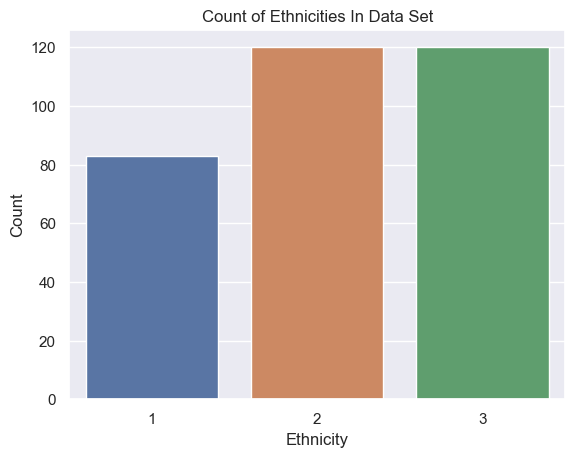

In [6]:
sns.countplot(tumordata, x = "Ethnicity").set(title = "Count of Ethnicities In Data Set", ylabel = "Count")

In [ ]:
# Features: Ethnicity, tumor type, HER2 and ER status, and grade of the tumor
# Target Variable: Tumor size
cleaned_df = tumor_df[(tumor_df != 999).all(axis=1)]
col_cat = 'Tsize60'
all_cols5 = ['TumorType', 'ER', 'Her2', 'Grade', 'GradeT', 'GradeN', 'GradeM']

In [ ]:

# KNN Model with Popularity Column ~ Model 1

# Encode Tumor Type
encoded_ttype = 

# Train/Test Split Data
X = cleaned_df[['Dropped','Popularity','Completed']]
y = df_merged[col_cat]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)


params_to_try = {'n_neighbors':range(1,30)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try, cv=5)
knn_search.fit(X_train, y_train)
knn_predictions1 = knn_search.predict(X_test)
knn_score1 = knn_search.score(X_test, y_test)
cv1= knn_search.best_params_['n_neighbors']

# KNN Model without Popularity Column ~ Model 2

# Train/Test Split Data
X2 = df_merged[['Dropped','Completed']]
y2 = df_merged[col_cat]
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=7)

params_to_try = {'n_neighbors':range(1,30)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try, cv=5)
knn_search.fit(X2_train, y2_train)
knn_predictions2 = knn_search.predict(X2_test)
knn_score2 = knn_search.score(X2_test, y2_test)
cv2 = knn_search.best_params_['n_neighbors']

accuracy_model1 = knn_score1
accuracy_model2 = knn_score2

# To plot the confusion matrix, call the function in the new cell below.
# The autograder may not run any code added after the plot_confusion_matrix or ConfusionMatrixDisplay functions.


# Leave these here to help with grading.
print('Model 1 Accuracy:', accuracy_model1)
print('Model 2 Accuracy:', accuracy_model2)
print('Optimal n_neighors for Model 1:', cv1)
print('Optimal n_neighors for Model 2:', cv2)